In [1]:
import os
import torch
import sys
sys.path.append('../../lib/exlib/src')

import sys
sys.path.append('../../src')
import sop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sop.utils.seed_all(42)

# config
exp_config = sop.tasks.cosmogrid.CosmogridConfig()
val_config = exp_config.get_config('test')
val_config['evaluation']['batch_size'] = 16
val_config

/opt/conda/envs/rapids/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/envs/rapids/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may hav

{'dataset': {'name': 'cosmogrid',
  'root': '/shared_data0/weiqiuy/datasets/cosmogrid'},
 'training': {'batch_size': 16,
  'num_epochs': 20,
  'mask_batch_size': 64,
  'optimizer': {'name': 'adamw', 'lr': 5e-06, 'weight_decay': 0.01}},
 'evaluation': {'split': 'test', 'num_data': -1, 'batch_size': 16},
 'model': {'type': 'cnn',
  'base': '/scratch/datasets/cosmogrid/CNN_mass_maps.pth',
  'sop': '/shared_data0/weiqiuy/sop/notebooks/exps/cosmogrid_lr5e-06_tgtnnz0.2_gg0.0600_gs10.0000_ft_identify_fixk_scratch_ks1_segpatch_4h/best',
  'num_classes': 2}}

In [2]:
# model
backbone_model, original_model, processor, backbone_config, model, config = sop.tasks.cosmogrid.get_model(
    val_config['model']['type'],
    backbone_model_name=val_config['model']['base'],
    backbone_processor_name=val_config['model']['base'],
    sop_model_name=val_config['model']['sop'],
    eval_mode=True
)
backbone_model = backbone_model.to(device)
original_model = original_model.to(device)
model = model.to(device)

projection layer is not frozen
projection layer is not frozen
Loaded step 17101


In [3]:
# data

val_dataset, val_dataloader = sop.tasks.cosmogrid.get_dataset(val_config['dataset']['name'], 
                                          split=val_config['evaluation']['split'], 
                                          num_data=val_config['evaluation']['num_data'],
                                          batch_size=val_config['evaluation']['batch_size'],
                                          processor=processor,
                                          config=config)

# samples used for training: 80000
# samples used for validation: 10000
# samples used for testing: 10000
# total samples: 100000
x shape (80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
y shape (80000, 6) (10000, 6) (10000, 6)
masks shape (80000, 66, 66) (10000, 66, 66) (10000, 66, 66)
-- ALL --
max 0.5298399945920093
min -0.035092697370729765
-- SPLIT test --
max 0.5298399945920093
min -0.035092697370729765
Finished loading 10000 test images ... 


In [4]:
# exp_dir = '/shared_data0/weiqiuy/sop/exps/cosmogrid_cnn/attributions'
exp_dir = '/shared_data0/weiqiuy/sop/exps/cosmogrid_cnn/attributions_test'

# Save

In [5]:
from tqdm.auto import tqdm

# explainer_name = 'lime'
# explainer_name = 'mfaba'
# explainer_name = 'ampe' # checked
explainer_name = 'agi' # cls only


explainer = sop.tasks.cosmogrid.get_explainer(original_model, backbone_model, explainer_name, device)

output_dirname = os.path.join(exp_dir, f'{explainer_name}_{val_config["evaluation"]["split"]}')
os.makedirs(output_dirname, exist_ok=True)

count = 0

for batch in tqdm(val_dataloader):

    inputs, labels, masks, masks_i = batch
    inputs = inputs.to(device, dtype=torch.float)
    labels = labels.to(device, dtype=torch.float)
    masks = masks.to(device)
    
    original_logits = backbone_model(inputs).logits
    
    labels_omega = torch.zeros(labels.shape[0]).long().to(device)
    labels_sigma = torch.ones(labels.shape[0]).long().to(device)
    
    expln_omega = explainer(inputs, labels_omega)
    expln_sigma = explainer(inputs, labels_sigma)
    
    bsz = inputs.shape[0]
    
    for i in tqdm(range(bsz)):
        output_filepath = os.path.join(output_dirname, f'{count}.pt')
        if os.path.exists(output_filepath):
            count += 1
            continue

        entry = {'image': inputs[i],
                 'original_logits': original_logits[i],
                 'omega_mask': expln_omega.attributions[i],
                 'sigma_mask': expln_sigma.attributions[i],
                'label': labels[i],
                 'omega_group_mask': expln_omega.group_masks[i] if 'group_masks' in expln_omega._fields else None,
                 'sigma_group_mask': expln_sigma.group_masks[i] if 'group_masks' in expln_sigma._fields else None,
                 'omega_group_attr': expln_omega.group_attributions[i] if 'group_attributions' in expln_omega._fields else None,
                 'sigma_group_attr': expln_sigma.group_attributions[i] if 'group_attributions' in expln_sigma._fields else None,
                'num_labels': config.num_labels}

        torch.save(entry, output_filepath)
        count += 1

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

TypeError: expected Tensor as element 0 in argument 0, but got int

# Load

In [3]:
import os
import torch
import sys
sys.path.append('../../lib/exlib/src')

import sys
sys.path.append('../../src')
import sop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sop.utils.seed_all(42)

from sop.metrics import get_cosmo_purity_results, get_acc_frac_bright_dark

In [4]:
methods = [
    'shap_20_test',
    'lime_20_test',
    'rise_20_test',
    'intgrad_20_test',
    'gradcam_test',
    'archipelago_test',
    'fullgrad_test',
    'mfaba_test',
    'ampe_test'
]

In [44]:
results_all = {}
for method in methods:
    print(method)
    result = get_acc_frac_bright_dark(method, backbone_model, original_model, model, k=0.2, data_size=1000, skip=True)
    results_all[method] = result

shap_20_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.028261217474469698 original loss 0.00868941234914798
lime_20_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.04932804668572187 original loss 0.00868941234914798
rise_20_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.035710256371073355 original loss 0.00868941234914798
intgrad_20_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.04161104926398756 original loss 0.00868941234914798
gradcam_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.0355413724038434 original loss 0.00868941234914798
archipelago_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.0689786855717622 original loss 0.00868941234914798
fullgrad_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.03629019818488034 original loss 0.00868941234914798
mfaba_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.03522307852888064 original loss 0.007622627807396246
ampe_test


  0%|          | 0/1000 [00:00<?, ?it/s]

masked loss 0.037060314969364426 original loss 0.007622978377901697


In [45]:
results_purity_all = {}
threshold_bright = 0.015
threshold_dark = 0.6

for method in methods:
    results_purity_all[method] = get_cosmo_purity_results(results_all[method]['frac_bright_all'], results_all[method]['frac_dark_all'], 
                                             threshold_bright=threshold_bright, threshold_dark=threshold_dark)

In [46]:
import torch
results = {k: {**results_all[k], **results_purity_all[k]} for k in results_all}
results['shap_20_test'].keys()

dict_keys(['loss_all', 'loss_original', 'frac_bright_all', 'frac_dark_all', 'omega_bright', 'omega_dark', 'sigma_bright', 'sigma_dark', 'purity_mean', 'purity_std', 'omega_bright_flat', 'omega_dark_flat', 'sigma_bright_flat', 'sigma_dark_flat'])

In [47]:
torch.save(results, 'cosmo_acc_pur.pt')

In [48]:
input_filename = '/shared_data0/weiqiuy/sop/notebooks/neurips2024_figs/cosmogrid_sop_results_all_thresholds.pt'
results_all_thresholds_sop = torch.load(input_filename)

In [49]:
results_all_thresholds_sop[tuple([threshold_bright, threshold_dark])].keys()

dict_keys(['omega_bright', 'omega_dark', 'sigma_bright', 'sigma_dark', 'mean', 'omega_bright_flat', 'omega_dark_flat', 'sigma_bright_flat', 'sigma_dark_flat'])

In [50]:
import copy
results['sop'] = copy.deepcopy(results_all_thresholds_sop[tuple([threshold_bright, threshold_dark])])

In [51]:
import json
with open('/shared_data0/weiqiuy/sop/notebooks/neurips2024_figs/cosmogrid_sop_loss.json', 'rt') as input_file:
    results_loss_sop = json.load(input_file)
    
# results_baselines_all['sop'] = results_sop_all
# results_loss['sop'] = results_loss_sop
results_loss_sop.keys()
results['sop'].update(results_loss_sop)

# Vis

In [58]:
name_mapping = {
    'lime_20_test': 'LIME-F',
    'shap_20_test': 'SHAP-F',
    'rise_20_test': 'RISE-F',
    'intgrad_20_test': 'IG-F',
    'gradcam_test': 'GC-F',
    'fullgrad_test': 'FG-F',
    'archipelago_test': 'Archi.-F',
    'mfaba_test': 'MFABA-F',
    'ampe_test': 'AMPE-F',
    'sop': 'SOP (ours)'
}

In [69]:
from sop.metrics import plot_mse_vs_purity

ImportError: cannot import name 'plot_mse_vs_purity' from 'sop.metrics' (/shared_data0/weiqiuy/sop/notebooks/metrics/../../src/sop/metrics/__init__.py)

  0%|          | 0/4 [00:00<?, ?it/s]

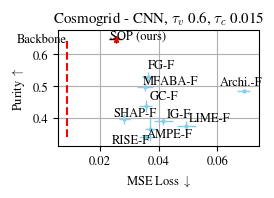

In [59]:
table_stats = plot_mse_vs_purity(results, threshold_bright=0.015, threshold_dark=0.6)

In [60]:
table_stats.keys()

dict_keys(['loss_mean', 'purity_mean', 'loss_std', 'purity_std', 'methods'])

In [68]:
for idx in range(len(table_stats['methods'])):
    loss_format = f'{table_stats["loss_mean"][idx]:.3f} $\\pm$ {table_stats["loss_std"][idx]:.3f}'
    purity_format = f'{table_stats["purity_mean"][idx]:.3f} $\\pm$ {table_stats["purity_std"][idx]:.3f}'
    
    print(f'{table_stats["methods"][idx]} & {loss_format} & {purity_format} \\\\')

LIME-F & 0.049 $\pm$ 0.003 & 0.375 $\pm$ 0.018 \\
SHAP-F & 0.028 $\pm$ 0.002 & 0.397 $\pm$ 0.016 \\
RISE-F & 0.036 $\pm$ 0.003 & 0.342 $\pm$ 0.006 \\
IG-F & 0.042 $\pm$ 0.003 & 0.391 $\pm$ 0.011 \\
GC-F & 0.036 $\pm$ 0.002 & 0.438 $\pm$ 0.019 \\
FG-F & 0.036 $\pm$ 0.002 & 0.529 $\pm$ 0.016 \\
Archi.-F & 0.069 $\pm$ 0.002 & 0.487 $\pm$ 0.004 \\
MFABA-F & 0.035 $\pm$ 0.003 & 0.498 $\pm$ 0.014 \\
AMPE-F & 0.037 $\pm$ 0.002 & 0.366 $\pm$ 0.037 \\
SOP (ours) & 0.025 $\pm$ 0.002 & 0.647 $\pm$ 0.011 \\


In [ ]:
plot_mse_vs_purity(results, threshold_bright=0.015, threshold_dark=0.6, save_Dir )

  0%|          | 0/4 [00:00<?, ?it/s]

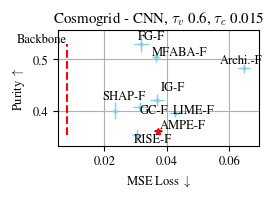

In [18]:
plot_mse_vs_purity(results, threshold_bright=0.015, threshold_dark=0.6)

In [57]:
tbs = [0.005, 0.01, 0.015, 0.02, 0.025]
tds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for tb in tbs:
    for td in tds:
        print(tb, td)
        plot_mse_vs_purity(results, threshold_bright=tb, threshold_dark=td, save_dir='cosmo_figs')

0.005 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.1_tc0.005.pdf
0.005 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.2_tc0.005.pdf
0.005 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.3_tc0.005.pdf
0.005 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.4_tc0.005.pdf
0.005 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.5_tc0.005.pdf
0.005 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.6_tc0.005.pdf
0.005 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.7_tc0.005.pdf
0.005 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.8_tc0.005.pdf
0.005 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.9_tc0.005.pdf
0.01 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.1_tc0.01.pdf
0.01 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.2_tc0.01.pdf
0.01 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.3_tc0.01.pdf
0.01 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.4_tc0.01.pdf
0.01 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.5_tc0.01.pdf
0.01 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.6_tc0.01.pdf
0.01 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.7_tc0.01.pdf
0.01 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.8_tc0.01.pdf
0.01 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.9_tc0.01.pdf
0.015 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.1_tc0.015.pdf
0.015 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.2_tc0.015.pdf
0.015 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.3_tc0.015.pdf
0.015 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.4_tc0.015.pdf
0.015 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.5_tc0.015.pdf
0.015 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.6_tc0.015.pdf
0.015 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.7_tc0.015.pdf
0.015 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.8_tc0.015.pdf
0.015 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.9_tc0.015.pdf
0.02 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.1_tc0.02.pdf
0.02 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.2_tc0.02.pdf
0.02 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.3_tc0.02.pdf
0.02 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.4_tc0.02.pdf
0.02 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.5_tc0.02.pdf
0.02 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.6_tc0.02.pdf
0.02 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.7_tc0.02.pdf
0.02 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.8_tc0.02.pdf
0.02 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.9_tc0.02.pdf
0.025 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.1_tc0.025.pdf
0.025 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.2_tc0.025.pdf
0.025 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.3_tc0.025.pdf
0.025 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.4_tc0.025.pdf
0.025 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.5_tc0.025.pdf
0.025 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.6_tc0.025.pdf
0.025 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.7_tc0.025.pdf
0.025 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.8_tc0.025.pdf
0.025 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

cosmo_figs/mse_loss_vs_purity_cosmogrid_tv0.9_tc0.025.pdf


0.005 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

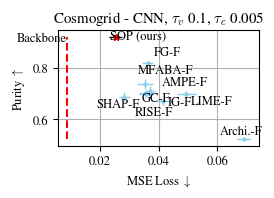

0.005 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

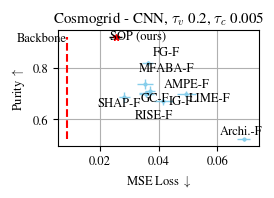

0.005 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

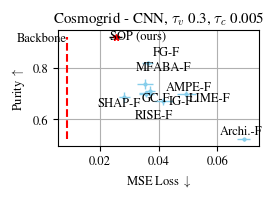

0.005 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

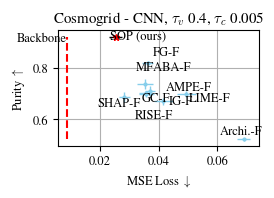

0.005 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

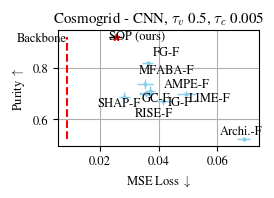

0.005 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

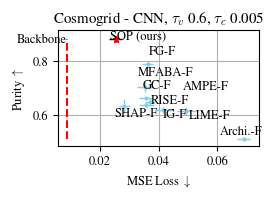

0.005 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

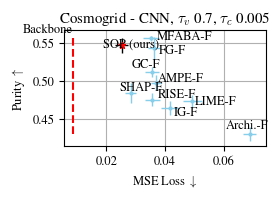

0.005 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

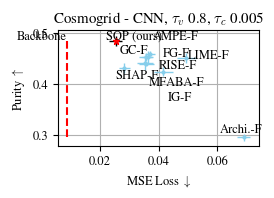

0.005 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

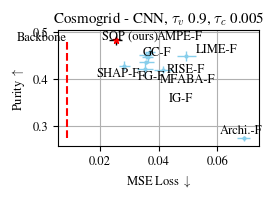

0.01 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

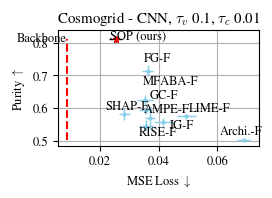

0.01 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

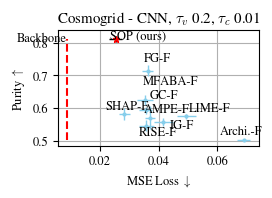

0.01 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

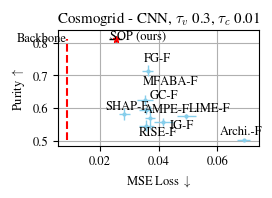

0.01 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

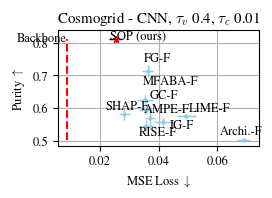

0.01 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

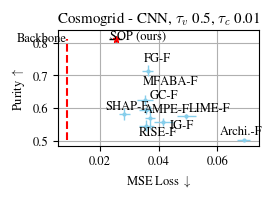

0.01 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

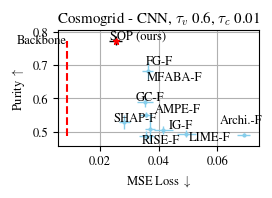

0.01 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

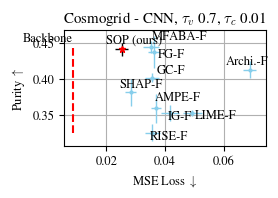

0.01 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

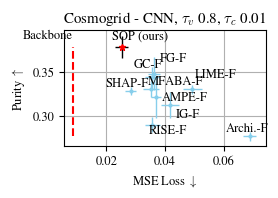

0.01 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

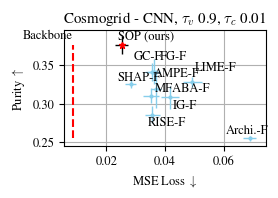

0.015 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

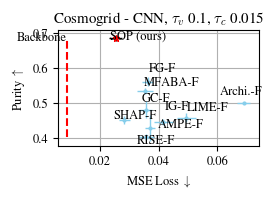

0.015 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

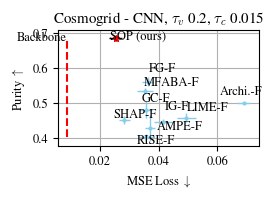

0.015 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

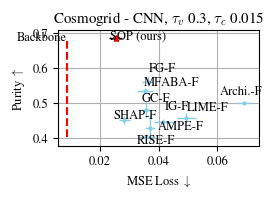

0.015 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

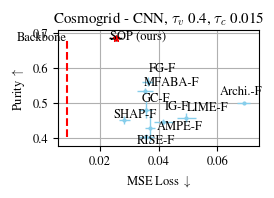

0.015 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

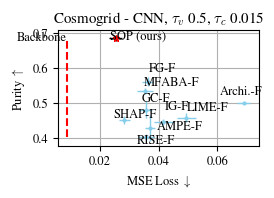

0.015 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

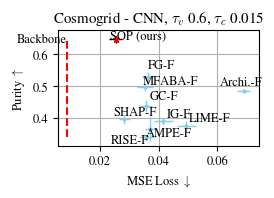

0.015 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

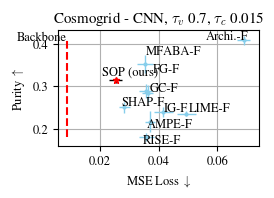

0.015 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

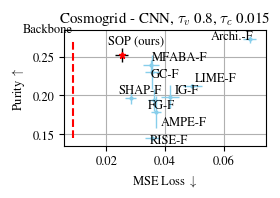

0.015 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

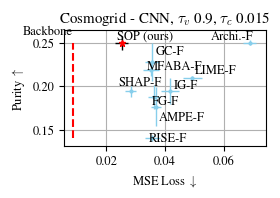

0.02 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

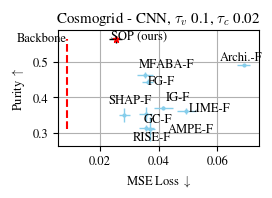

0.02 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

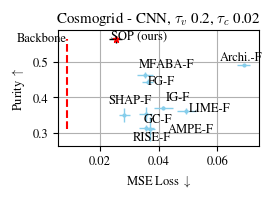

0.02 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

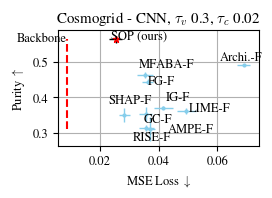

0.02 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

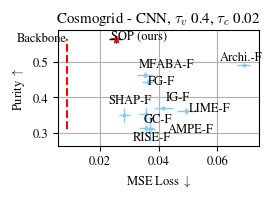

0.02 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

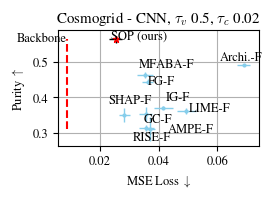

0.02 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

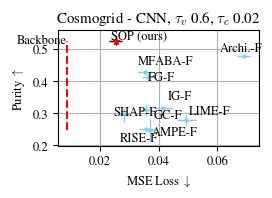

0.02 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

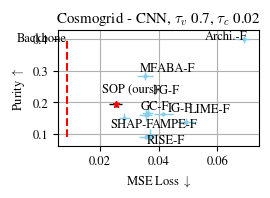

0.02 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

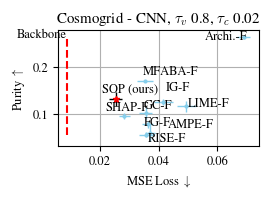

0.02 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

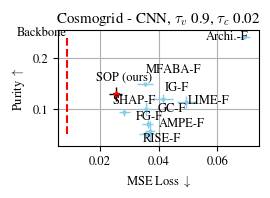

0.025 0.1


  0%|          | 0/4 [00:00<?, ?it/s]

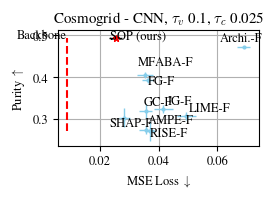

0.025 0.2


  0%|          | 0/4 [00:00<?, ?it/s]

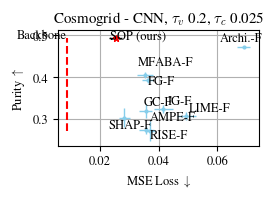

0.025 0.3


  0%|          | 0/4 [00:00<?, ?it/s]

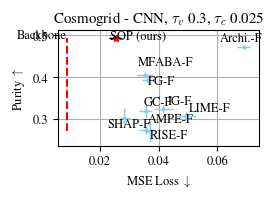

0.025 0.4


  0%|          | 0/4 [00:00<?, ?it/s]

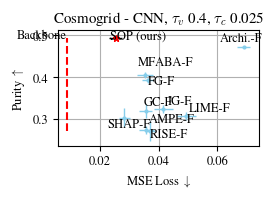

0.025 0.5


  0%|          | 0/4 [00:00<?, ?it/s]

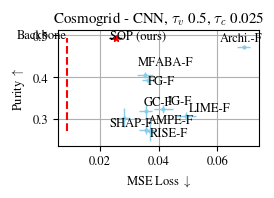

0.025 0.6


  0%|          | 0/4 [00:00<?, ?it/s]

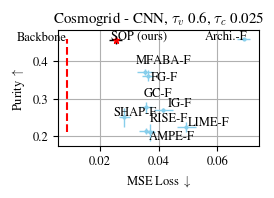

0.025 0.7


  0%|          | 0/4 [00:00<?, ?it/s]

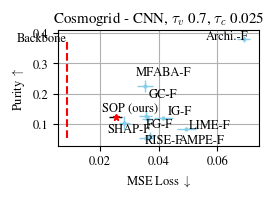

0.025 0.8


  0%|          | 0/4 [00:00<?, ?it/s]

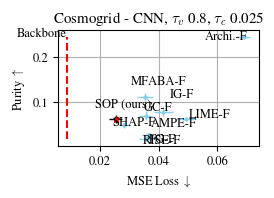

0.025 0.9


  0%|          | 0/4 [00:00<?, ?it/s]

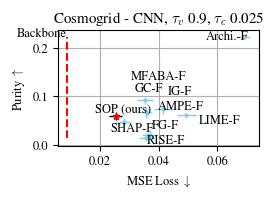

In [53]:
tbs = [0.005, 0.01, 0.015, 0.02, 0.025]
tds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for tb in tbs:
    for td in tds:
        print(tb, td)
        plot_mse_vs_purity(results, threshold_bright=tb, threshold_dark=td)

In [41]:
results['lime_20_test'].keys()

dict_keys(['loss_all', 'loss_original', 'frac_bright_all', 'frac_dark_all', 'omega_bright', 'omega_dark', 'sigma_bright', 'sigma_dark', 'mean', 'std', 'omega_bright_flat', 'omega_dark_flat', 'sigma_bright_flat', 'sigma_dark_flat'])

In [22]:
import numpy as np

name_mapping = {
    'lime_20_test': 'LIME',
    'shap_20_test': 'SHAP',
    'rise_20_test': 'RISE',
    'intgrad_20_test': 'IG',
    'gradcam_test': 'GC',
    'fullgrad_test': 'FG',
    'archipelago_test': 'Archi.',
    'mfaba_test': 'MFABA',
    'ampe_test': 'AMPE',
    'sop': 'SOP'
}

for method in results_all:
    print(f'{name_mapping[method]} & {np.mean(results_all[method]["loss_all"]):.4f}\\\\')

SHAP & 0.0278\\
LIME & 0.0607\\
RISE & 0.0387\\
IG & 0.0447\\
GC & 0.0328\\
Archi. & 0.0828\\
FG & 0.0317\\
MFABA & 0.0306\\
AMPE & 0.0322\\
